## Milestone Project: Time Series Forecasting (BitPredict💰📈)
We're going to be building a series of models in an attempt to predict the price of Bitcoin

### Get the Data

In [1]:
import pandas as pd

data = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                   parse_dates=['Date'],
                   index_col='Date')
data.sample(5)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-03-24,BTC,557.168330,562.953330,570.330810,551.163310
2019-07-18,BTC,9733.132134,9490.438127,9972.245110,9085.489499
2018-03-05,BTC,11558.475000,11171.817500,11574.941250,11067.785000
2017-01-04,BTC,1047.099990,1028.333750,1048.123750,1013.377500
2018-11-14,BTC,6282.438677,6327.154697,6331.487634,6245.238174


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [3]:
# only want closing price for each day
data = pd.DataFrame(data['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'price'})
data.sample(5)

,price
Date,
2013-11-22,681.33000
2017-07-04,2640.06125
2015-05-17,236.33900
2017-04-27,1289.74750
2017-07-31,2718.61750


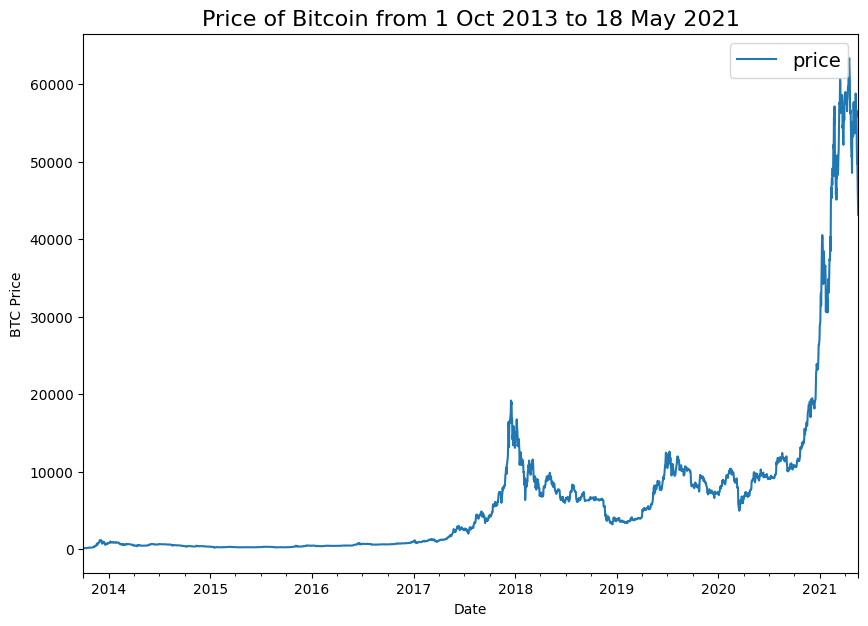

In [4]:
import matplotlib.pyplot as plt
data.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

### Creating a train-test-split for time series data

In [5]:
from sklearn.model_selection import train_test_split
# get bitcoin data array
timesteps = data.index.to_numpy()
prices = data['price'].to_numpy()

# split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)
len(x_train), len(x_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

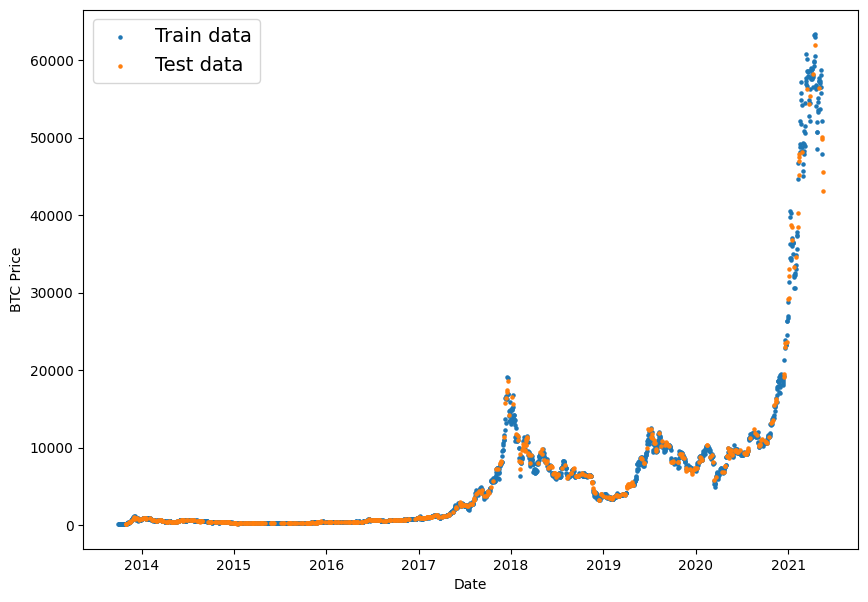

In [6]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(x_train, y_train, s=5, label="Train data")
plt.scatter(x_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

what's wrong with this plot?

Well, let's remind ourselves of what we're trying to do.

We're trying to use the historical price of Bitcoin to predict future prices of Bitcoin.

With this in mind, our seen data (training set) is what?

Prices of Bitcoin in the past.

And our unseen data (test set) is?

Prices of Bitcoin in the future.

Does the plot above reflect this?

No.

Our test data is scattered all throughout the training data.

This kind of random split is okay for datasets without a time component (such as images or passages of text for classification problems) but for time series, we've got to take the time factor into account.

To fix this, we've got to split our data in a way that reflects what we're actually trying to do.

We need to split our historical Bitcoin data to have a dataset that reflects the past (train set) and a dataset that reflects the future (test set).

### Create a train-test-split for time series (The Right Way)

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)

In [7]:
split_size = int(.8 * len(prices))

x_train, y_train = timesteps[:split_size], prices[:split_size]

x_test, y_test = timesteps[split_size:], prices[split_size:]

len(x_train), len(x_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

In [8]:
# Creating a plotting function
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

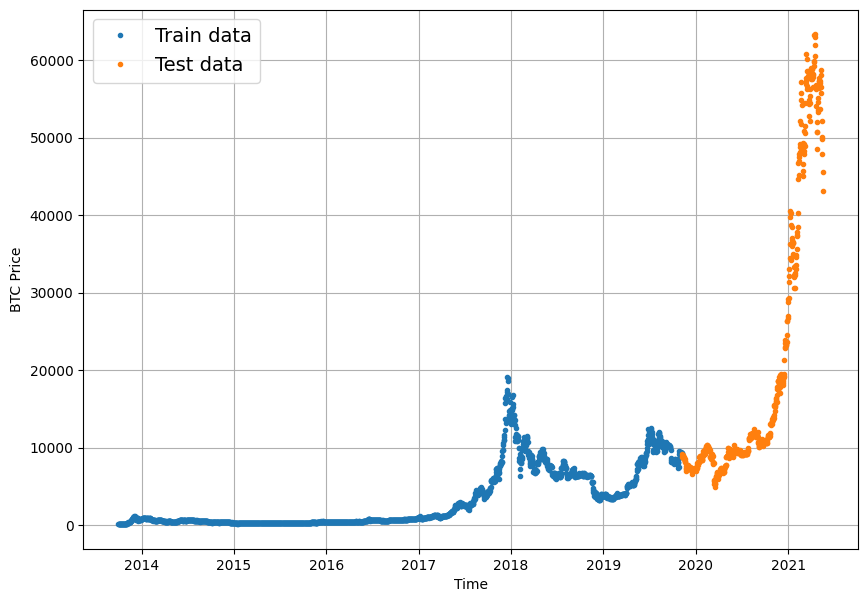

In [9]:
# Try out our plotting function
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = x_train, values = y_train, label = "Train data")
plot_time_series(timesteps = x_test, values = y_test, label = "Test data")

### Modeling Experiments

#### Model 0: Naive Forecast (baseline)

In [10]:
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

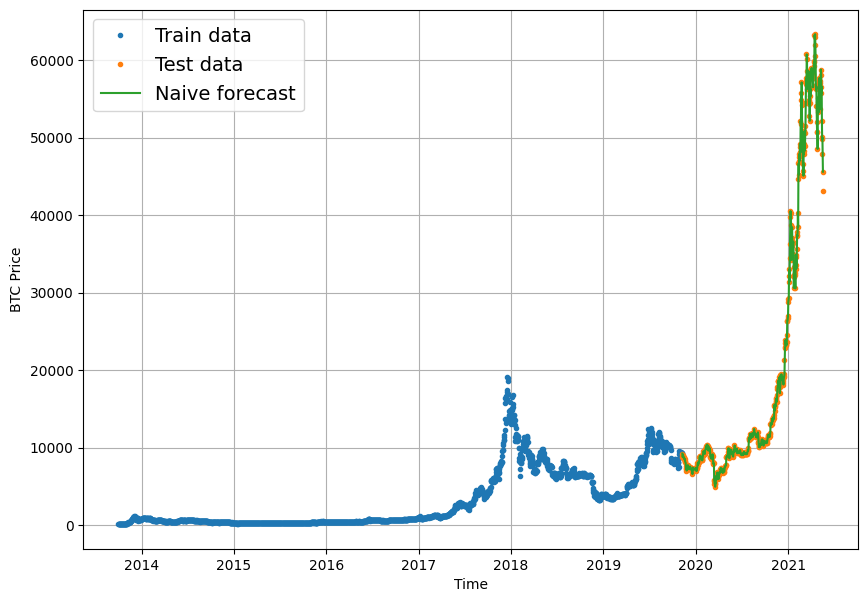

In [11]:
# plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_train, values=y_train, label="Train data")
plot_time_series(timesteps=x_test, values=y_test, label="Test data")
plot_time_series(timesteps=x_test[1:], values=naive_forecast, start=0, format="-", label="Naive forecast")

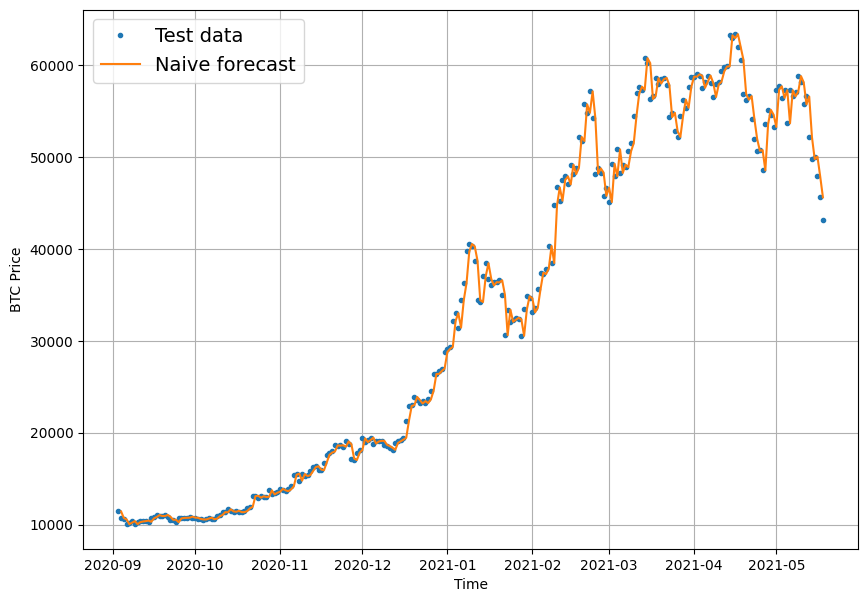

In [12]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=x_test, values=y_test, start = offset, label="Test data")
plot_time_series(timesteps=x_test[1:], values=naive_forecast, start=offset, format="-", label="Naive forecast")

#### Evaluating a Time Series Model

In [13]:
# MASE implemented courtesy of sktime
import tensorflow as tf

def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # find MAE of naive forecast
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)
    return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's mae_loss(). In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.



In [14]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.MeanAbsoluteError()
    mse = tf.keras.metrics.MeanSquaredError()
    mape = tf.keras.metrics.MeanAbsolutePercentageError()

    mae.update_state(y_true, y_pred)
    mse.update_state(y_true, y_pred)
    mape.update_state(y_true, y_pred)

    rmse = tf.sqrt(mse.result())
    mase = mean_absolute_scaled_error(y_true, y_pred)  # Ensure this function is defined elsewhere

    return {
        "mae": mae.result().numpy(),
        "mse": mse.result().numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.result().numpy(),
        "mase": mase.numpy(),
    }


In [15]:
naive_results = evaluate_preds(y_true = y_test[1:], y_pred = naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?




In [16]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

Okay, looking at these two values is starting to give us an idea of how our model is performing:

The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

Each prediction in naive forecast is on average off by: $567



### Format Data : Windowing Dataset
    Windowing is a method to turn a time series dataset into supervised learning problem.

    In other words, we want to use windows of the past to predict the future.

    For example for a univariate time series, windowing for one week (window=7) to predict the next single value (horizon=1) might look like:

```bash
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

**Or for the price of Bitcoin, it'd look like:**
```bash
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)

In [17]:
horizon = 1
window_size = 7

In [18]:
# create a function to label windowed data
def get_labelled_windows(x, horizon = 1):
    return x[:, :-horizon], x[:, -horizon:]

# test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis=0), horizon=horizon)
tf.squeeze(test_window).numpy(), tf.squeeze(test_label).numpy()

(array([1, 2, 3, 4, 5, 6, 7]), 8)

Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Let's write a function which:

    1. Creates a window step of specific window size, for example: [[0, 1, 2, 3, 4, 5, 6, 7]]
    2. Uses NumPy indexing to create a 2D of multiple window steps
    3. Uses the 2D array of multuple window steps to index on a target series
    4. Uses the get_labelled_windows() function we created above to turn the window steps into windows with a specified horizon

In [19]:
# create a function to view NumPy arrays as windows
import numpy as np

def make_windows(x, window_size = 7, horizon = 1):
    # 1. Create a window of specific window_size (add the horizon on the end for labelling)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    print(f"Window step:\n {window_step}")
    
    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    print(f"Window indexes:\n {window_indexes}")
    
    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    
    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon = horizon)
    
    return windows, labels

In [20]:
full_windows, full_labels = make_windows(prices, window_size = window_size, horizon = horizon)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 [[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]


In [21]:
len(full_windows), len(full_labels)

(2780, 2780)

In [22]:
# view the first 3 windows
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning Windows into training and test sets

In [23]:
# make train/test splits
def make_train_test_splits(windows, labels, test_split = 0.2):
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [24]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [25]:
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [26]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-horizon-1]), y_train[window_size:])

True

#### Make a Modelling Checkpoint

In [27]:
import os
import tensorflow as tf

def create_model_checkpoint(model_name, save_path="model_experiments"):
    # Ensure the directory exists
    os.makedirs(save_path, exist_ok=True)
    # Add `.keras` extension to the file path
    filepath = os.path.join(save_path, f"{model_name}.keras")
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath,  # Create filepath to save the model
        verbose=0,  # Only output limited text
        save_best_only=True  # Save only the best model
    )

### Model 1: Dense Model (horizon = 1, Window = 7)

In [28]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(horizon, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

In [29]:
# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1683.9955 - mae: 1683.9955 - val_loss: 2370.2314 - val_mae: 2370.2314
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 344.3516 - mae: 344.3516 - val_loss: 1451.8679 - val_mae: 1451.8679
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 196.6925 - mae: 196.6925 - val_loss: 1171.3619 - val_mae: 1171.3619
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 175.6747 - mae: 175.6747 - val_loss: 1024.5018 - val_mae: 1024.5018
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 167.4032 - mae: 167.4032 - val_loss: 960.4520 - val_mae: 960.4520
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 162.2283 - mae: 162.2283 - val_loss: 915.1914 - val_mae: 915.1914
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 157.8870 - mae: 157.8870 - val_loss: 880.4379 - val_mae: 880.4379
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 153.1717 - mae: 153.1717 - val_loss: 885.1117 - val_mae

In [30]:
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 288.8172 - mae: 288.8172 


[572.9179077148438, 572.9179077148438]

In [31]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments\model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DELL\AppData\Local\Temp\ipykernel_6664\550945197.py:2: SyntaxWarning: invalid escape sequence '\m'
  model_1 = tf.keras.models.load_model("model_experiments\model_1_dense.keras")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 284.6536 - mae: 284.6536  


[568.9823608398438, 568.9823608398438]

In [32]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

In [33]:
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8849.3955, 8763.706 , 9048.381 , 8785.672 , 8714.474 , 8756.555 ,
       8680.044 , 8508.015 , 8463.209 , 8529.394 ], dtype=float32)>

In [34]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.98236,
 'mse': 1163453.9,
 'rmse': 1078.6351,
 'mape': 2.550149,
 'mase': 0.99954444}

In [35]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

It looks like our naïve model beats our first deep model on nearly every metric.



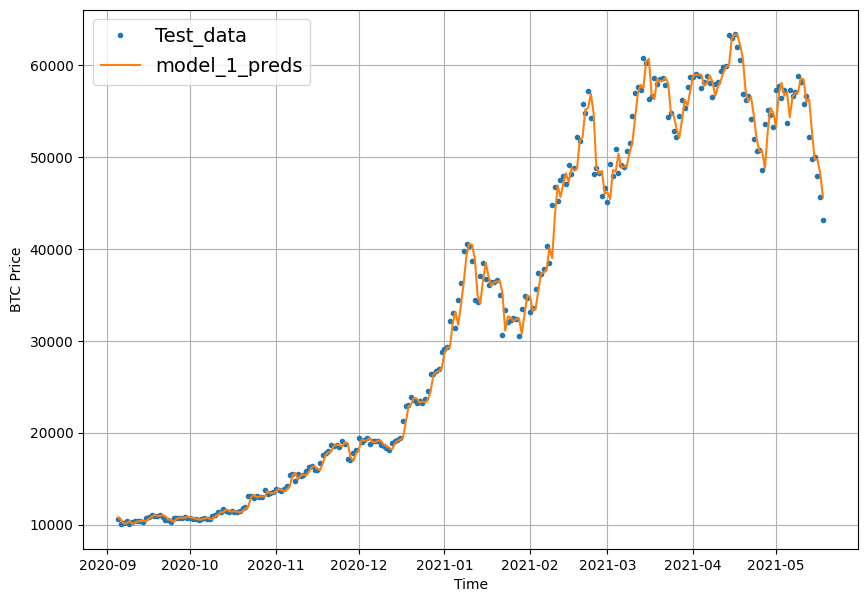

In [36]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (horizon = 1, window = 30)

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-price-window-for-one-month.png)

In [37]:
horizon = 1
window_size = 30

# make a windowed dataset with the appropriate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=window_size, horizon=horizon)
len(full_windows), len(full_labels)

Window step:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]
Window indexes:
 [[   0    1    2 ...   28   29   30]
 [   1    2    3 ...   29   30   31]
 [   2    3    4 ...   30   31   32]
 ...
 [2754 2755 2756 ... 2782 2783 2784]
 [2755 2756 2757 ... 2783 2784 2785]
 [2756 2757 2758 ... 2784 2785 2786]]


(2757, 2757)

In [38]:
# make train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [39]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(horizon, activation="linear")
], name="model_2_dense")

model_2.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae"])

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4098.4468 - mae: 4098.4468 - val_loss: 4914.4487 - val_mae: 4914.4487
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 663.4097 - mae: 663.4097 - val_loss: 2563.5405 - val_mae: 2563.5405
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 466.2859 - mae: 466.2859 - val_loss: 1734.9763 - val_mae: 1734.9763
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 343.2992 - mae: 343.2992 - val_loss: 1683.1230 - val_mae: 1683.1230
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 289.8862 - mae: 289.8862 - val_loss: 1351.7968 - val_mae: 1351.7968
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 251.5719 - mae: 251.5719 - val_loss: 1266.6324 - val_mae: 1266.6324
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 227.2164 - mae: 227.2164 - val_loss: 1445.5452 - val_mae: 1445.5452
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 234.7685 - mae: 234.7685 - val_loss: 1470.5975 - 

In [40]:
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 349.0177 - mae: 349.0177 


[665.1178588867188, 665.1178588867188]

In [41]:
# load in best performing model_2 and evaluate on test data
model_2 = tf.keras.models.load_model("model_experiments\model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DELL\AppData\Local\Temp\ipykernel_6664\249908888.py:2: SyntaxWarning: invalid escape sequence '\m'
  model_2 = tf.keras.models.load_model("model_experiments\model_2_dense.keras")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 317.6524 - mae: 317.6524  


[617.1446533203125, 617.1446533203125]

In [42]:
# get forecasts predictions
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8864.075 , 8878.72  , 8814.    , 8582.509 , 8410.189 , 8403.113 ,
       8206.515 , 8157.7803, 7978.856 , 7806.2085], dtype=float32)>

In [43]:
# evaluate model_2 preds
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 617.1447,
 'mse': 1303585.9,
 'rmse': 1141.7468,
 'mape': 2.8313975,
 'mase': 1.0787749}

In [44]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

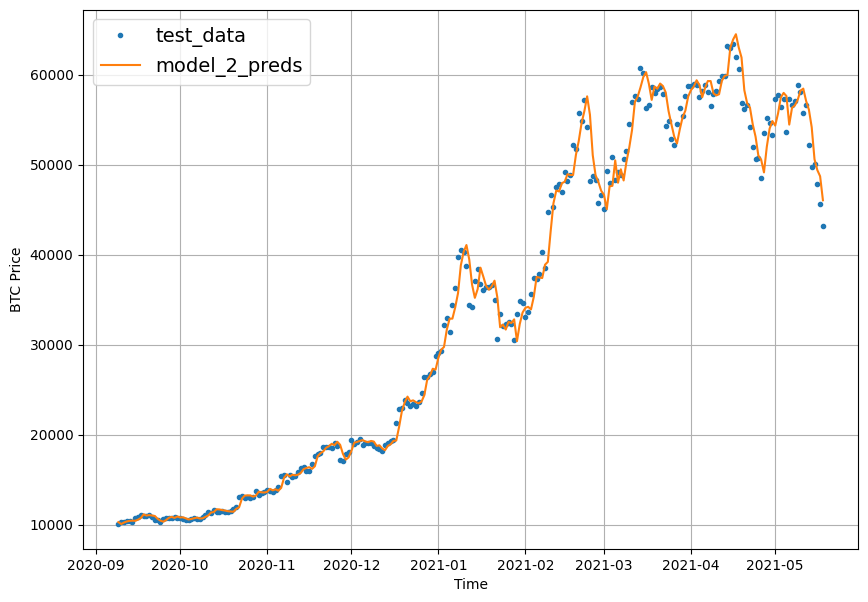

In [45]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

### Model 3: Dense (horizon = 7, window = 30)

In [46]:
horizon = 7
window_size = 30

# make a windowed dataset with the appropriate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=window_size, horizon=horizon)
len(full_windows), len(full_labels)

Window step:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]
Window indexes:
 [[   0    1    2 ...   34   35   36]
 [   1    2    3 ...   35   36   37]
 [   2    3    4 ...   36   37   38]
 ...
 [2748 2749 2750 ... 2782 2783 2784]
 [2749 2750 2751 ... 2783 2784 2785]
 [2750 2751 2752 ... 2784 2785 2786]]


(2751, 2751)

In [47]:
# make train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [48]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(horizon, activation="linear")
], name="model_3_dense")

model_3.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae"])

model_3.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1454.9440 - mae: 1454.9440 - val_loss: 2985.0571 - val_mae: 2985.0571
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 552.2615 - mae: 552.2615 - val_loss: 2180.3618 - val_mae: 2180.3618
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 445.4269 - mae: 445.4269 - val_loss: 2076.9763 - val_mae: 2076.9763
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 405.3132 - mae: 405.3132 - val_loss: 2075.6724 - val_mae: 2075.6724
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 378.7785 - mae: 378.7785 - val_loss: 1966.7289 - val_mae: 1966.7289
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 352.4534 - mae: 352.4534 - val_loss: 1792.6049 - val_mae: 1792.6049
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 331.8525 - mae: 331.8525 - val_loss: 1678.4515 - val_mae: 1678.4515
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 323.5135 - mae: 323.5135 - val_loss: 1576.6418 - 

In [49]:
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 617.1160 - mae: 617.1160 


[1235.006591796875, 1235.006591796875]

In [50]:
# load in best performing model_3 and evaluate on test data
model_3 = tf.keras.models.load_model("model_experiments\model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DELL\AppData\Local\Temp\ipykernel_6664\407380789.py:2: SyntaxWarning: invalid escape sequence '\m'
  model_3 = tf.keras.models.load_model("model_experiments\model_3_dense.keras")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 617.4534 - mae: 617.4534  


[1230.862060546875, 1230.862060546875]

In this case, the error will be higher because we're predicting 7 steps at a time.

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).



In [51]:
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[9385.526 , 9374.565 , 9232.321 , 9227.739 , 9323.552 , 9111.951 ,
        9164.279 ],
       [8980.436 , 8776.23  , 8853.952 , 8821.058 , 9047.925 , 8881.189 ,
        8632.182 ],
       [8788.34  , 8629.047 , 8791.8545, 8745.64  , 9070.022 , 8925.762 ,
        8612.041 ],
       [9022.671 , 8858.123 , 8980.08  , 9193.53  , 9192.288 , 9190.281 ,
        8888.873 ],
       [8807.554 , 8737.985 , 8885.0205, 9219.454 , 8914.183 , 9311.327 ,
        8758.185 ],
       [8894.851 , 8797.077 , 8852.415 , 9177.006 , 8887.776 , 9234.019 ,
        8758.959 ],
       [8967.493 , 8828.013 , 8963.486 , 9209.155 , 8937.155 , 9131.542 ,
        8814.34  ],
       [8732.819 , 8593.313 , 8664.546 , 8827.421 , 8735.679 , 8720.853 ,
        8483.36  ],
       [8643.068 , 8480.955 , 8259.498 , 8412.812 , 8492.261 , 8362.285 ,
        8130.354 ],
       [8394.534 , 8237.085 , 8208.78  , 8165.9326, 8351.261 , 8186.9233,
        8171.5913]], dtype=floa

#### Make Evaluation Function Work For Large Horizons

In [52]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Initialize metrics
    mae = tf.keras.metrics.MeanAbsoluteError()
    mse = tf.keras.metrics.MeanSquaredError()
    mape = tf.keras.metrics.MeanAbsolutePercentageError()

    # Update states
    mae.update_state(y_true, y_pred)
    mse.update_state(y_true, y_pred)
    mape.update_state(y_true, y_pred)

    # Compute metrics
    mae_result = mae.result().numpy()
    mse_result = mse.result().numpy()
    mape_result = mape.result().numpy()
    rmse = tf.sqrt(mse.result()).numpy()
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Return metrics as dictionary
    return {
        "mae": mae_result,
        "mse": mse_result,
        "rmse": rmse,
        "mape": mape_result,
        "mase": mase.numpy() if hasattr(mase, 'numpy') else mase
    }

In [53]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': 1230.862,
 'mse': 5260019.0,
 'rmse': 2293.4731,
 'mape': 5.52311,
 'mase': 2.19025}

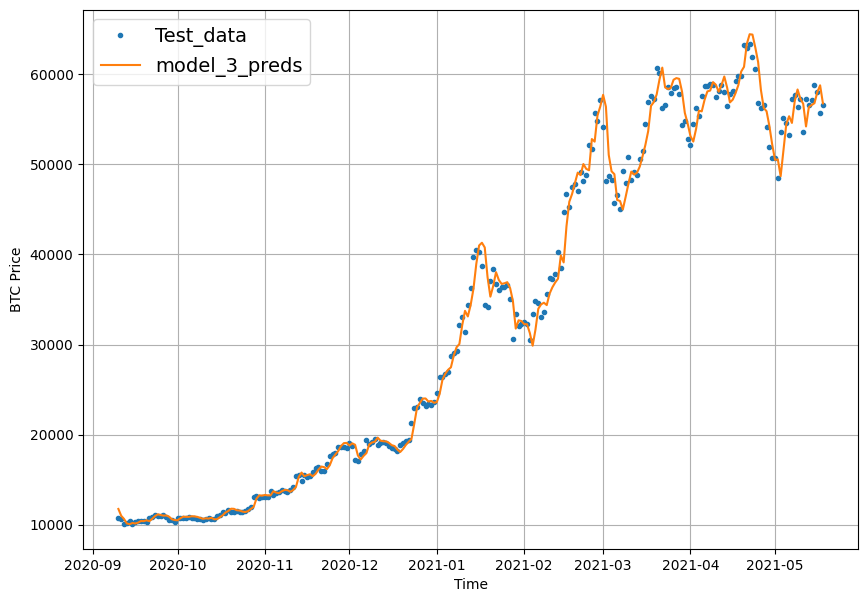

In [54]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=x_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=x_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

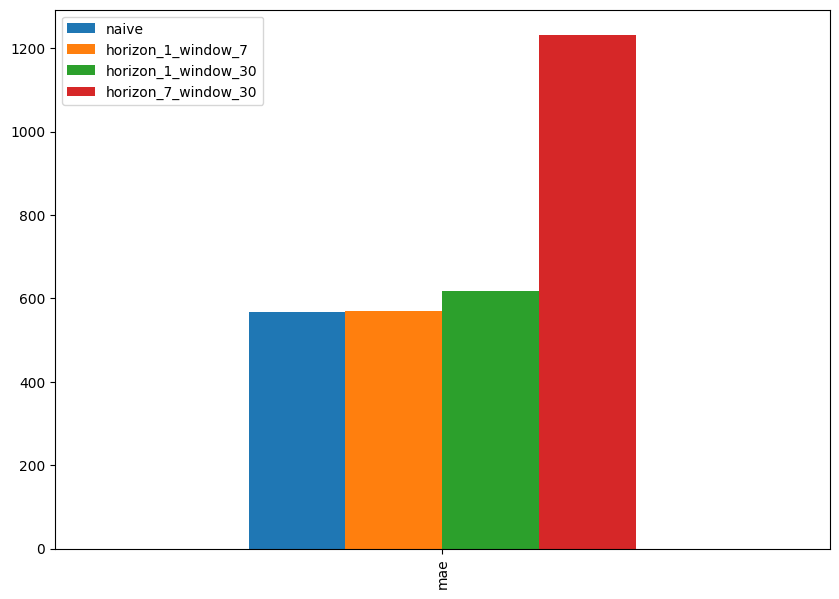

In [55]:
# Which of the previous models is performing best so far?
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [56]:
horizon = 1
window_size = 7

# window data
full_windows, full_labels = make_windows(prices, window_size=window_size, horizon=horizon)
len(full_windows), len(full_labels)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 [[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]


(2780, 2780)

In [57]:
# create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Now, since we're going to be using Conv1D layers, we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim).

In our case, the batch_size (by default this is 32 but we can change it) is handled for us but the other values will be:

timesteps = WINDOW_SIZE - the timesteps is also often referred to as features, our features are the previous WINDOW_SIZE values of Bitcoin
input_dim = HORIZON - our model views WINDOW_SIZE (one week) worth of data at a time to predict HORIZON (one day)

In [58]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [59]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    # Reshape input to be 3D
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(horizon, activation="linear")
], name="model_4_conv1d")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2425.9355 - mae: 2425.9355 - val_loss: 1123.4482 - val_mae: 1123.4482
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 361.3015 - mae: 361.3015 - val_loss: 1973.3210 - val_mae: 1973.3210
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 256.3788 - mae: 256.3788 - val_loss: 1104.6099 - val_mae: 1104.6099
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 184.5366 - mae: 184.5366 - val_loss: 1060.5519 - val_mae: 1060.5519
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 175.3679 - mae: 175.3679 - val_loss: 1045.1479 - val_mae: 1045.1479
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 172.8505 - mae: 172.8505 - val_loss: 1022.5726 - val_mae: 1022.5726
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 170.6925 - mae: 170.6925 - val_loss: 990.5653 - val_mae: 990.5654
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 168.2039 - mae: 168.2039 - val_loss: 978.3220 - va

In [60]:
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 287.4628 - mae: 287.4628 


[571.5172119140625, 571.5172119140625]

In [61]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8913.716, 8836.635, 9077.632, 8822.781, 8791.941, 8797.658,
       8717.528, 8573.1  , 8514.034, 8570.004], dtype=float32)>

In [62]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_4_preds)
model_4_results

{'mae': 571.5172,
 'mse': 1180381.5,
 'rmse': 1086.4536,
 'mape': 2.557855,
 'mase': 1.0039974}

### Model 5: Recurrent Neural Network

In [63]:
# build a recurrent neural network
tf.random.set_seed(42)

inputs = layers.Input(shape=(window_size,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(inputs) 
# x = layers.LSTM(128, activation='relu', return_sequences=True)(x) # ensure LSTM returns sequences
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(23, activation='relu')(x)

outputs = layers.Dense(horizon)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_5_lstm")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2132.7334 - mae: 2132.7334 - val_loss: 2161.1218 - val_mae: 2161.1218
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 340.6457 - mae: 340.6457 - val_loss: 1052.0365 - val_mae: 1052.0365
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 189.7969 - mae: 189.7969 - val_loss: 1088.9625 - val_mae: 1088.9625
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 193.2842 - mae: 193.2842 - val_loss: 1276.2511 - val_mae: 1276.2511
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 189.9391 - mae: 189.9391 - val_loss: 1113.7979 - val_mae: 1113.7979
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 173.8089 - mae: 173.8089 - val_loss: 1069.2303 - val_mae: 1069.2303
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 183.6111 - mae: 183.6111 - val_loss: 1049.6906 - val_mae: 1049.6906
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 185.3698 - mae: 185.3698 - val_loss: 1292.

In [64]:
model_5.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 436.7207 - mae: 436.7207 


[829.5225830078125, 829.5225830078125]

In [65]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8634.458, 8555.45 , 8758.614, 8524.162, 8478.662, 8497.907,
       8428.575, 8284.372, 8225.68 , 8278.382], dtype=float32)>

In [66]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 829.5225,
 'mse': 1878709.5,
 'rmse': 1370.6603,
 'mape': 3.9428658,
 'mase': 1.4572413}

### Make a Multivariate Time Series

Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving)

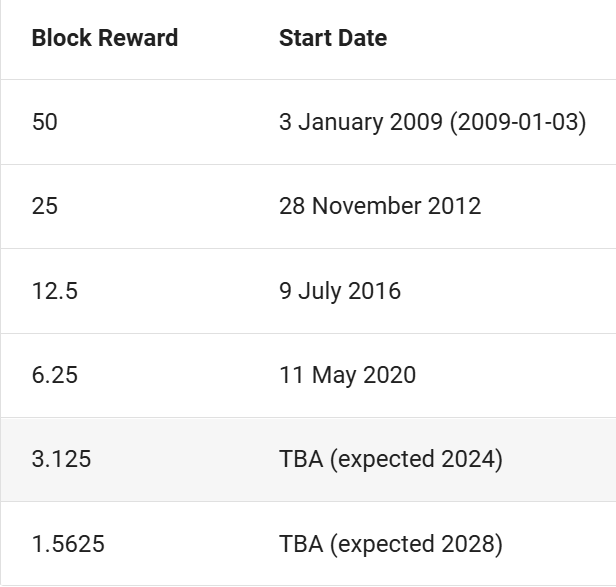

In [69]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - data.index[0]).days
block_reward_3_days = (block_reward_4_datetime - data.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [70]:
# Add block_reward column
bitcoin_prices_block = data.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


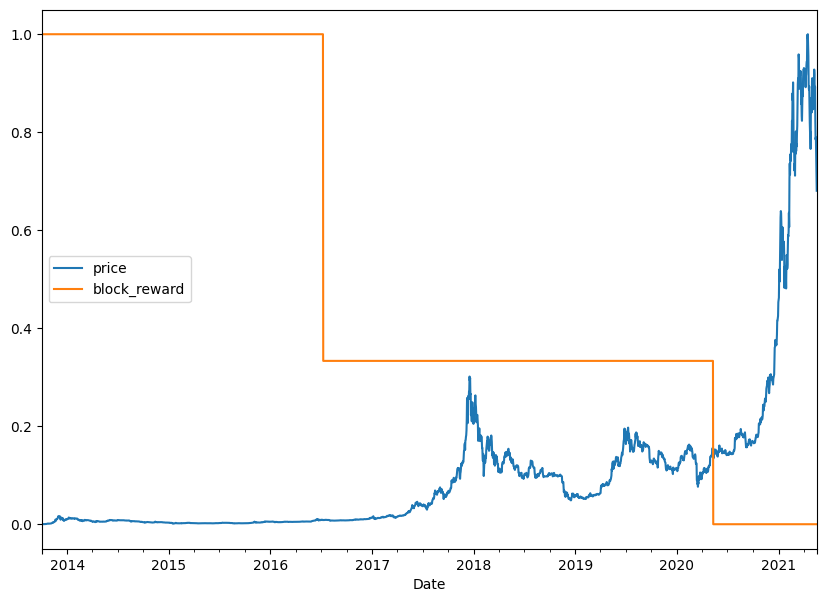

In [72]:
# Plot the block reward/price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.



### Making Windowed Dataset with Pandas

Previously, we used some custom made functions to window our univariate time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the pandas.DataFrame.shift() method to create a windowed multivariate time series.



In [73]:
import pandas as pd

horizon = 1
window_size = 7

# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(window_size): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"price+{i+1}"] = bitcoin_prices_windowed["price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,price,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [74]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["price"].astype(np.float32)
X.head()

,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [75]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: price, dtype: float32

In [76]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (Multivariate Time Series)

In [77]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(horizon, activation="linear")
], name="model_6_dense")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_6.fit(X_train, y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2046.2876 - mae: 2046.2876 - val_loss: 2956.9700 - val_mae: 2956.9700
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 359.7227 - mae: 359.7227 - val_loss: 1035.1610 - val_mae: 1035.1610
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 194.8306 - mae: 194.8306 - val_loss: 1033.2430 - val_mae: 1033.2430
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 179.2502 - mae: 179.2502 - val_loss: 999.4328 - val_mae: 999.4328
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 171.1027 - mae: 171.1027 - val_loss: 1014.6656 - val_mae: 1014.6656
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 167.9623 - mae: 167.9623 - val_loss: 970.5190 - val_mae: 970.5190
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 163.3952 - mae: 163.3952 - val_loss: 955.9608 - val_mae: 955.9608
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 160.1268 - mae: 160.1268 - val_loss: 913.2908 - val_mae

In [78]:
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 284.8502 - mae: 284.8502 


[571.9006958007812, 571.9006958007812]

In [79]:
# load in best performing model_6 and evaluate on test data
model_6 = tf.keras.models.load_model("model_experiments\model_6_dense.keras")
model_6.evaluate(X_test, y_test)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DELL\AppData\Local\Temp\ipykernel_6664\2023871562.py:2: SyntaxWarning: invalid escape sequence '\m'
  model_6 = tf.keras.models.load_model("model_experiments\model_6_dense.keras")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 285.2450 - mae: 285.2450  


[571.421142578125, 571.421142578125]

In [80]:
model_6_preds = make_preds(model_6, X_test)
model_6_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8832.411, 8785.894, 9056.225, 8753.453, 8726.664, 8776.821,
       8643.983, 8527.38 , 8453.284, 8528.791], dtype=float32)>

In [81]:
model_6_results = evaluate_preds(y_true=y_test, y_pred=model_6_preds)
model_6_results

{'mae': 571.42114,
 'mse': 1172134.0,
 'rmse': 1082.6514,
 'mape': 2.5591557,
 'mase': 1.0038286}

### Model 7: N-BEATS algorithm¶


So far we've tried a bunch of smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm does.



#### Building and testing an N-BEATS block layer¶


In [82]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-basic-block-replication-with-tensorflow-layer-subclassing.png)

In [84]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=window_size, 
                                       theta_size=window_size+horizon, # backcast + forecast 
                                       horizon=horizon,
                                       n_neurons=128,
                                       n_layers=4)

In [85]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(window_size) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [86]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.10700545 -0.18717046  0.3643788  -0.42847237 -0.6744956   0.31631812
  0.41481957]
Forecast: 0.247419074177742


#### Preparing data for the N-BEATS algorithm using tf.data¶


In [87]:
data.head()

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [88]:
horizon = 1
window_size = 7

In [89]:
# Add windowed columns
bitcoin_prices_nbeats = data.copy()
for i in range(window_size):
  bitcoin_prices_nbeats[f"price+{i+1}"] = bitcoin_prices_nbeats["price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,price,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [90]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("price", axis=1)
y = bitcoin_prices_nbeats.dropna()["price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [91]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

#### Setting up hyperparameters for N-BEATS algorithm¶


Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.

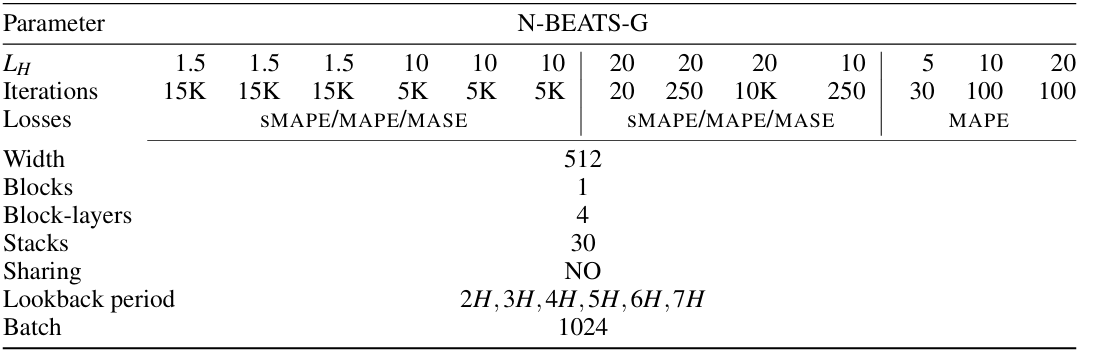

In [93]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = window_size * horizon # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + horizon

INPUT_SIZE, THETA_SIZE

(7, 8)

#### Getting ready for residual connections¶
there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the N-BEATS paper) possible:

- `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other
- `tf.keras.layers.add(inputs)` - adds list of input tensors to each other


Let's Try Them Out:

In [94]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


A residual connection (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:

Subtract the backcast outputs from a previous block from the backcast inputs to the current block
Add the forecast outputs from all blocks together in a stack

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)

#### Let's Building the Model

In [97]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=horizon,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=horizon,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Epoch 1/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 24912.0645 - mae: 24912.0645 - mse: 2543138048.0000 - val_loss: 8011.1958 - val_mae: 8011.1958 - val_mse: 117149000.0000 - learning_rate: 0.0010
Epoch 2/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 918ms/step - loss: 3885.4041 - mae: 3885.4041 - mse: 62124908.0000 - val_loss: 9495.6201 - val_mae: 9495.6201 - val_mse: 159397760.0000 - learning_rate: 0.0010
Epoch 3/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 786ms/step - loss: 761.6753 - mae: 761.6753 - mse: 4163608.7500 - val_loss: 2043.0146 - val_mae: 2043.0146 - val_mse: 12570368.0000 - learning_rate: 0.0010
Epoch 4/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 202.7237 - mae: 202.7237 - mse: 173247.9844 - val_loss: 1223.7664 - val_mae: 1223.7664 - val_mse: 3422163.0000 - learning_rate: 0.0010
Epoch 5/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 711ms/step - loss: 224.7617 - mae: 224.7617 - mse: 371580.3750 - val_loss: 1742.3066 - val_mae: 1742.3066 - val_mse: 6748436.5000 - learning_rate: 0.0010
Epoch 6/5000

In [98]:
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 579.3941 - mae: 579.3941 - mse: 1206050.1250


[579.3941040039062, 579.3941040039062, 1206050.125]

In [100]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8934.921, 8847.718, 9048.871, 8837.823, 8823.65 , 8788.883,
       8688.814, 8565.359, 8524.736, 8546.843], dtype=float32)>

In [101]:
model_7_results = evaluate_preds(y_true=y_test, y_pred=model_7_preds)
model_7_results

{'mae': 579.3942,
 'mse': 1206050.4,
 'rmse': 1098.2032,
 'mape': 2.6371698,
 'mase': 1.0178351}

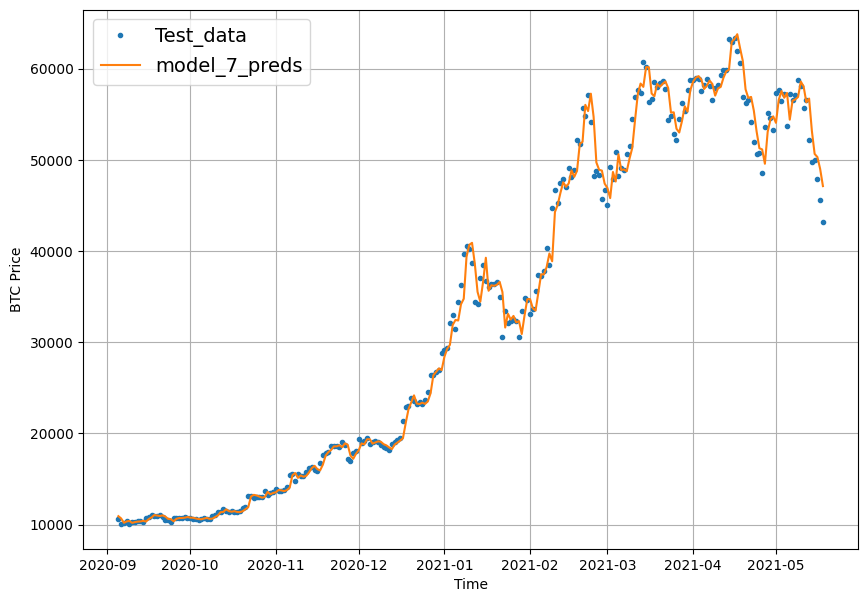

In [111]:
# plot the n-beats model
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=x_test[-len(y_test):], values=y_test, start=offset, label="Test_data")
plot_time_series(timesteps=x_test[-len(y_test):], values=model_7_preds, start=offset, format="-", label="model_7_preds")

### Model 8: Creating an Ensemble (stacking diffrent Models together)
To create our ensemble models we're going to be using a combination of:

Different loss functions (MAE, MSE, MAPE)
Randomly initialized models


In [112]:
def get_ensemble_models(horizon=horizon, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(horizon)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,  # prevent large amount of training outputs
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

**Let's try it out by running num_iter=5 runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).**

In [113]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 430: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 845: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 945: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 346: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 446: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 197: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 679: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 779: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 389: ReduceLROnPl

In [114]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [115]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8814.675,  8746.511,  9063.901, ..., 50200.594, 48478.855,
        45862.82 ],
       [ 8802.351,  8771.935,  9021.826, ..., 50010.32 , 48339.996,
        45997.62 ],
       [ 8784.105,  8745.339,  9047.954, ..., 49813.133, 48233.51 ,
        45633.652],
       ...,
       [ 8747.47 ,  8745.544,  9085.571, ..., 50385.656, 48773.65 ,
        45631.086],
       [ 8828.342,  8714.536,  9014.738, ..., 49470.043, 48216.273,
        46097.496],
       [ 8816.48 ,  8784.221,  9053.648, ..., 49452.625, 48323.004,
        46076.57 ]], dtype=float32)>

In [116]:
ensumble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_preds)
ensumble_results

{'mae': 576.9337,
 'mse': 1175460.8,
 'rmse': 1084.1866,
 'mape': 2.6212997,
 'mase': 1.0135128}

#### Plotting the prediction intervals (uncertainty estimates) of our ensemble¶


One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


In [117]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

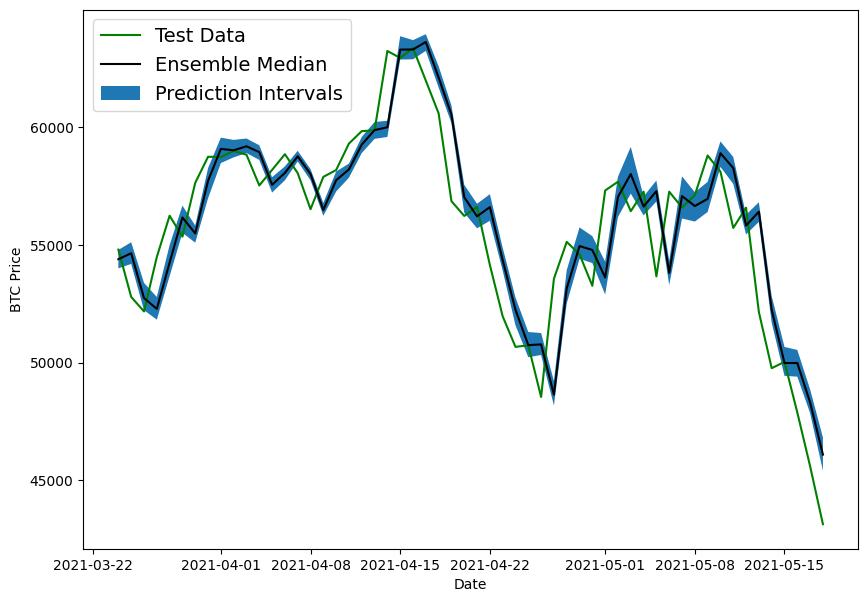

In [118]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be overfitting the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.



### Model 9: Train a model on the full historical data to make predictions into future¶


In [119]:
bitcoin_prices_windowed.head()

,price,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [121]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["price"].to_numpy()

In [122]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [123]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(horizon)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=200,
            verbose=0) # don't print out anything, we've seen this all before

### Make predictions on the future¶


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)

flow chart representing the loop we're about to create for making forecasts. Not pictured: retraining a forecasting model every time a forecast is made & new data is acquired. For example, if you're predicting the price of Bitcoin daily, you'd want to retrain your model every day, since each day you're going to have a new data point to work with.



In [124]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=window_size) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-window_size:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-window_size:]
  
  return future_forecast

In [125]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

In [140]:
future_forecast = make_future_forecast(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=window_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55952.2734375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55952.2734375 ] -> Prediction: 52010.85546875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55952.2734375  52010.85546875] -> Prediction: 50047.640625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55952.2734375  52010.85546875 50047.640625  ] -> Prediction: 49881.1484375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55952.2734375
 52010.85546875 50047.640625   49881.1484375 ] -> Prediction: 46464.73828125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/st

In [127]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [141]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = data.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [142]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [143]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

In [144]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55952.273, 52010.855, 50047.64 , 49881.15 , 46464.74 ,
        45957.945, 47488.47 , 55453.58 , 51855.23 , 49948.777, 48969.68 ,
        46022.703, 47410.312, 50402.152], dtype=float32))

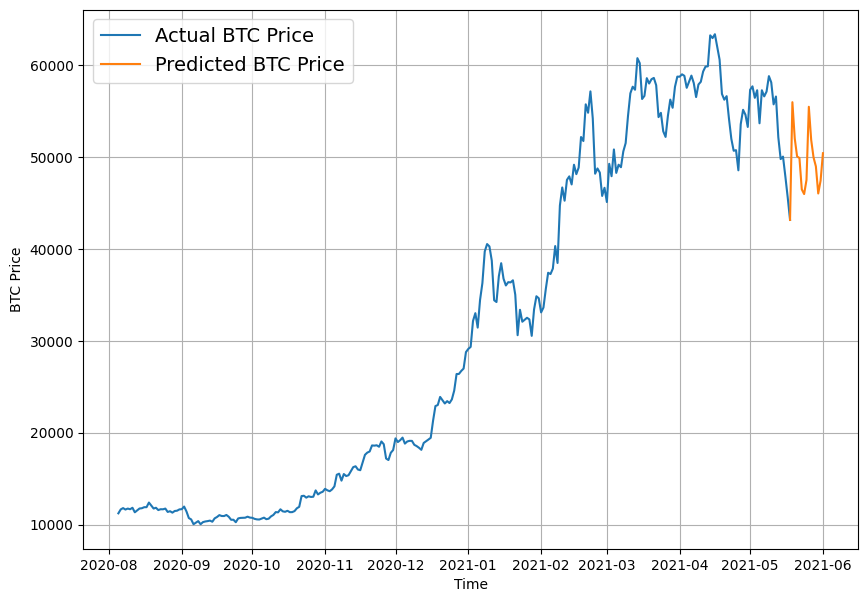

In [145]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(data.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

It looks like our predictions are starting to form a bit of a cyclic pattern (up and down in the same way).

Perhaps that's due to our model overfitting the training data and not generalizing well for future data. Also, as you could imagine, the further you predict into the future, the higher your chance for error


### Compare Models

In [147]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensumble_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.000,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.982361,1163453.875,1078.635132,2.550149,0.999544
model_2_dense_w30_h1,617.144714,1303585.875,1141.746826,2.831398,1.078775
model_3_dense_w30_h7,1230.862061,5260019.000,2293.473145,5.523110,2.190250
model_4_CONV1D,571.517212,1180381.500,1086.453613,2.557855,1.003997
model_5_LSTM,829.522522,1878709.500,1370.660278,3.942866,1.457241
model_6_multivariate,571.421143,1172134.000,1082.651367,2.559156,1.003829
model_8_NBEATs,579.394226,1206050.375,1098.203247,2.637170,1.017835
model_9_ensemble,576.933716,1175460.750,1084.186646,2.621300,1.013513


Text(0, 0.5, 'Mean Absolute Error (MAE)')

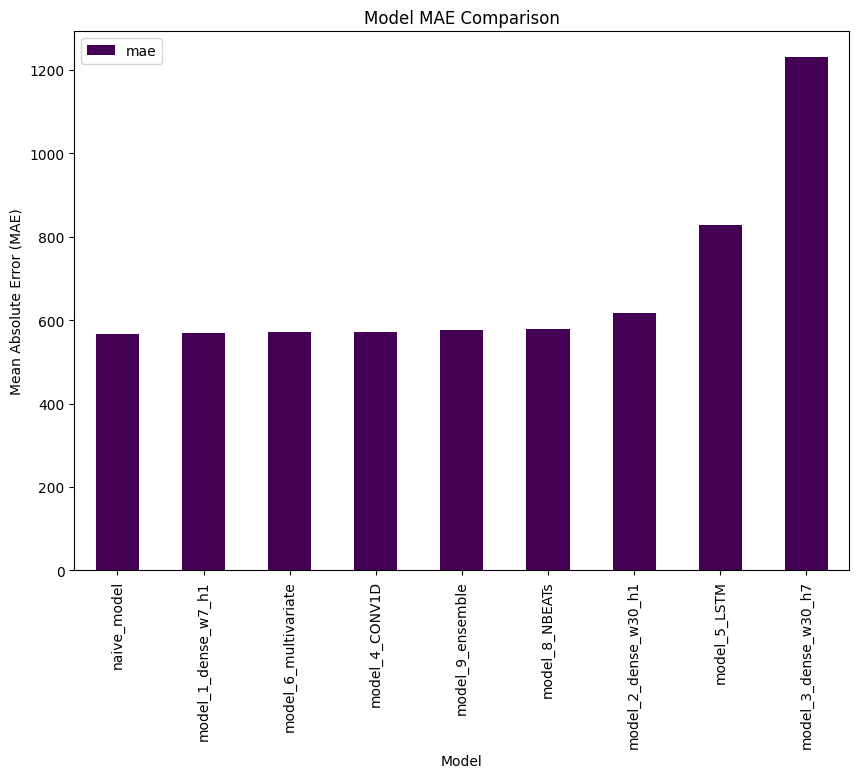

In [150]:
# Sort model results by MAE and plot them with custom colors
colors = plt.cm.viridis(np.linspace(0, 1, len(model_results)))
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar", color=colors)
plt.title("Model MAE Comparison")
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (MAE)")

![](https://th.bing.com/th/id/OIP.5Qd_LPR6A5ma3EDxKKU6FgHaEf?rs=1&pid=ImgDetMain)